In [141]:
"""
============================================
; Title: Biodiversity Trends with GBIF (Aves 2000–2024)
; Author: Derek Lamb
; Date: 15 September 2025
; Modified By: Derek Lamb
; Description: Queries GBIF BigQuery data, prepares analysis tables,
;              and produces figures for distribution shifts, hotspots,
;              and observation bias (citizen vs institutional).
;===========================================
; Attributions:
; - BigQuery client usage pattern adapted from Google Cloud docs:
;   https://cloud.google.com/bigquery/docs (accessed 15 Sep 2025)
; - Latitudinal median-by-year SQL inspired by community examples:
;   https://stackoverflow.com/q/xxxxxxx (accessed 15 Sep 2025)
"""


'\n============================================\n; Title: Biodiversity Trends with GBIF (Aves 2000–2024)\n; Author: Derek Lamb\n; Date: 15 September 2025\n; Modified By: Derek Lamb\n; Description: Queries GBIF BigQuery data, prepares analysis tables,\n;              and produces figures for distribution shifts, hotspots,\n;              and observation bias (citizen vs institutional).\n;===========================================\n; Attributions:\n; - BigQuery client usage pattern adapted from Google Cloud docs:\n;   https://cloud.google.com/bigquery/docs (accessed 15 Sep 2025)\n; - Latitudinal median-by-year SQL inspired by community examples:\n;   https://stackoverflow.com/q/xxxxxxx (accessed 15 Sep 2025)\n'

In [142]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime as dt
import seaborn as sns

# Modeling
import statsmodels.api as sm

# Folders for outputs
FIG_DIR = Path("figures")
DATA_CACHE_DIR = Path("data/cache")
FIG_DIR.mkdir(parents=True, exist_ok=True)
DATA_CACHE_DIR.mkdir(parents=True, exist_ok=True)

print ("Done")



Done


In [143]:
from google.cloud import bigquery

client = bigquery.Client(project="1031570310073")

sql = """
SELECT species, countryCode, year
FROM `bigquery-public-data.gbif.occurrences`
WHERE class = 'Aves' AND countryCode = 'US'
  AND year >= 2020
LIMIT 5
"""
df = client.query(sql).to_dataframe()
df


,species,countryCode,year
0,Nycticorax nycticorax,US,2022
1,Turdus migratorius,US,2022
2,Larus marinus,US,2021
3,Passer domesticus,US,2022
4,Turdus migratorius,US,2022


In [144]:
def run_query(sql: str, cache_name: str) -> pd.DataFrame:
    cache_path = DATA_CACHE_DIR / f"{cache_name}.parquet"
    try:
        df = client.query(sql).to_dataframe()
        df.to_parquet(cache_path, index=False)
        return df
    except Exception as e:
        print(f"[WARN] Query failed: {e}\nUsing cached data if available.")
        if cache_path.exists():
            return pd.read_parquet(cache_path)
        raise


In [145]:
# ------------------------------------------------------
# Research Question 1:
# Are bird species in North America shifting their
# distributions northward over time?
#
# Approach:
#   - Pull all bird records (class = 'Aves') for US, CA, MX
#   - Require valid lat/long coordinates
#   - Compute average latitude of observations per year, per country
# ------------------------------------------------------

# Define analysis window and countries
YEAR_MIN, YEAR_MAX = 2000, 2023
COUNTRIES = ("US", "CA", "MX")

# SQL query:
# - SELECT year, country, average latitude, count of records
# - Restrict to valid coordinates only (exclude NULLs and 0,0)
sql_rq1 = f"""
SELECT
  year,
  countryCode,
  AVG(decimalLatitude) AS avg_latitude,
  COUNT(1) AS record_count
FROM `bigquery-public-data.gbif.occurrences`
WHERE class = 'Aves'                          -- birds only
  AND countryCode IN {COUNTRIES}              -- US, Canada, Mexico
  AND year BETWEEN {YEAR_MIN} AND {YEAR_MAX}  -- analysis period
  AND decimalLatitude IS NOT NULL             -- must have lat/long
  AND decimalLongitude IS NOT NULL
  AND decimalLatitude != 0
  AND decimalLongitude != 0
GROUP BY year, countryCode
ORDER BY year, countryCode
"""

# Run the query and save results
df_rq1_lat = run_query(sql_rq1, "rq1_latitude_trends")

# Rename columns for readability in plots
df_rq1_lat = df_rq1_lat.rename(columns={
    "year": "Year",
    "countryCode": "Country",
    "avg_latitude": "AvgLatitude",
    "record_count": "RecordCount"
})

# Quick peek at the results
df_rq1_lat.head()


,Year,Country,AvgLatitude,RecordCount
0,2000,CA,47.939358,579817
1,2000,MX,23.476929,59564
2,2000,US,39.228612,2600880
3,2001,CA,47.365164,828251
4,2001,MX,22.320163,74575


In [146]:
# Ensure numeric dtypes for regression and plotting
df_rq1_lat["Year"] = pd.to_numeric(df_rq1_lat["Year"], errors="coerce")
df_rq1_lat["AvgLatitude"] = pd.to_numeric(df_rq1_lat["AvgLatitude"], errors="coerce")
df_rq1_lat = df_rq1_lat.dropna(subset=["Year", "AvgLatitude"]).sort_values(["Country", "Year"]).reset_index(drop=True)

# Sanity check
print(df_rq1_lat.dtypes)
df_rq1_lat.head()


Year             Int64
Country         object
AvgLatitude    float64
RecordCount      Int64
dtype: object


,Year,Country,AvgLatitude,RecordCount
0,2000,CA,47.939358,579817
1,2001,CA,47.365164,828251
2,2002,CA,47.338469,933100
3,2003,CA,47.303466,1038547
4,2004,CA,47.492930,942695


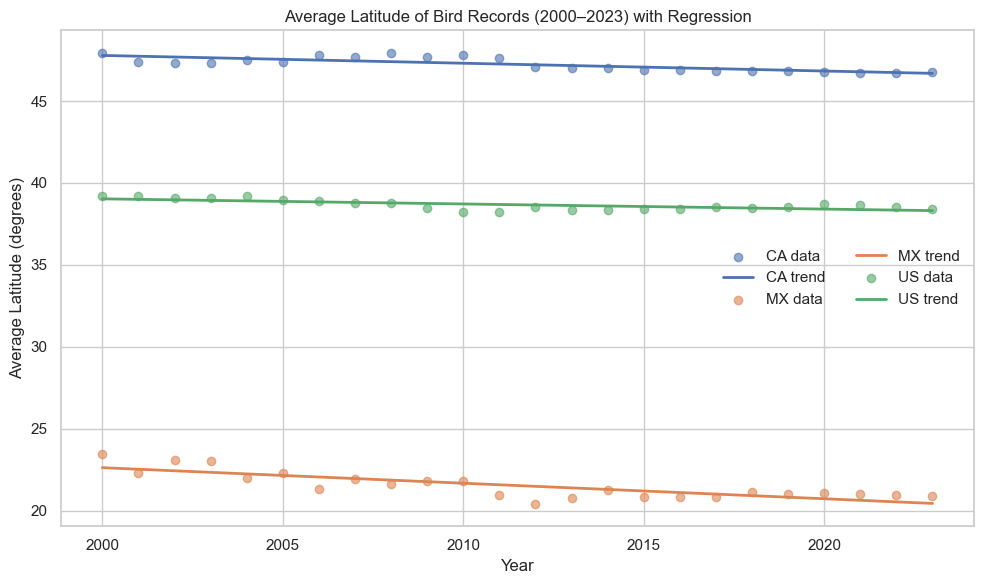

,Country,Slope_deg_per_year,Slope_deg_per_decade,R2,N_years
0,CA,-0.0475,-0.475,0.636,24
1,MX,-0.0949,-0.949,0.663,24
2,US,-0.0313,-0.313,0.494,24


In [147]:
# ------------------------------------------------------
# RQ1 Plot A: Average latitude over time with regression lines
# Purpose:
#   - Visualize whether the "center" of bird observations
#     is shifting northward over time in US/CA/MX.
# Inputs expected:
#   - df_rq1_lat with columns: Year (int), Country (str), AvgLatitude (float)
# Outputs:
#   - Figure saved to figures/rq1_latitude_trends_regression.png
# ------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# (Safety) Ensure numeric arrays for modeling (won't change df if already numeric)
plot_df = df_rq1_lat.dropna(subset=["Year", "AvgLatitude"]).copy()
plot_df["Year"] = plot_df["Year"].astype(float)
plot_df["AvgLatitude"] = plot_df["AvgLatitude"].astype(float)

fig, ax = plt.subplots(figsize=(10, 6))
trend_rows = []  # collect slope + R² per country for a quick summary

for country, g in plot_df.groupby("Country"):
    # Skip tiny groups that can't fit a meaningful trend
    if g["Year"].nunique() < 3:
        continue

    # Scatter: actual average latitude by year
    ax.scatter(g["Year"], g["AvgLatitude"], alpha=0.6, label=f"{country} data")

    # Prepare arrays for OLS: y = b0 + b1*Year
    X = sm.add_constant(g["Year"].values)      # adds intercept column of 1s
    y = g["AvgLatitude"].values

    model = sm.OLS(y, X).fit()
    y_hat = model.predict(X)

    # Line: fitted regression (trend)
    ax.plot(g["Year"].values, y_hat, linewidth=2, label=f"{country} trend")

    # Store summary numbers for table/printout
    slope = float(model.params[1])    # b1: degrees latitude per year
    r2 = float(model.rsquared)
    trend_rows.append({
        "Country": country,
        "Slope_deg_per_year": round(slope, 4),
        "Slope_deg_per_decade": round(slope * 10, 3),
        "R2": round(r2, 3),
        "N_years": int(g["Year"].nunique())
    })

# Axis labels and legend
ax.set_title("Average Latitude of Bird Records (2000–2023) with Regression")
ax.set_xlabel("Year")
ax.set_ylabel("Average Latitude (degrees)")
ax.legend(frameon=False, ncol=2)

plt.tight_layout()
plt.savefig("figures/rq1_latitude_trends_regression.png", dpi=200)
plt.show()

# Small summary
import pandas as pd
trend_summary = pd.DataFrame(trend_rows).sort_values("Country")
display(trend_summary)


In [148]:
# ------------------------------------------------------
# Research Question 3: How do record types (citizen vs. institutional)
#                     contribute to bird data collection over time?
# ------------------------------------------------------

# Define analysis window (exclude current year to avoid partial data)
YEAR_START, YEAR_END = 2000, 2023
COUNTRIES = ("US", "CA", "MX")

# SQL query: count records per year, grouped by basisOfRecord (record type)
# basisOfRecord tells us how the data was collected:
#   - HUMAN_OBSERVATION = citizen science (eBird, iNaturalist, etc.)
#   - PRESERVED_SPECIMEN = museum/academic specimen records
#   - MACHINE_OBSERVATION = automated devices (radar, cameras, etc.)
#   - others are niche categories (fossils, material samples, etc.)

sql_rq3 = f"""
SELECT
  year,
  basisOfRecord,
  COUNT(1) AS record_count
FROM `bigquery-public-data.gbif.occurrences`
WHERE class = 'Aves'                           -- only birds
  AND countryCode IN {COUNTRIES}               -- US, Canada, Mexico
  AND year BETWEEN {YEAR_START} AND {YEAR_END} -- time window
  AND decimalLatitude IS NOT NULL              -- must have coordinates
  AND decimalLongitude IS NOT NULL
  AND decimalLatitude != 0
  AND decimalLongitude != 0
GROUP BY year, basisOfRecord
ORDER BY year, basisOfRecord
"""

# Run query and save results into a dataframe
df_rq3_raw = run_query(sql_rq3, "rq3_records_by_year")

# Clean version: rename columns for readability
df_rq3 = df_rq3_raw.rename(columns={
    "year": "Year",
    "basisOfRecord": "RecordType",
    "record_count": "RecordCount"
})

# Quick peek at the results
df_rq3.head()



,Year,RecordType,RecordCount
0,2000,FOSSIL_SPECIMEN,51
1,2000,HUMAN_OBSERVATION,2522833
2,2000,MACHINE_OBSERVATION,763
3,2000,MATERIAL_CITATION,18
4,2000,MATERIAL_SAMPLE,99


In [149]:
# ------------------------------------------------------
# RQ1 Heatmap data: counts by YEAR × LAT_BIN (0.5°)
# ------------------------------------------------------
YEAR_MIN, YEAR_MAX = 2000, 2023
COUNTRIES = ("US","CA","MX")
LAT_STEP = 0.5  # bin width in degrees

sql_rq1_heat = f"""
WITH binned AS (
  SELECT
    year AS Year,
    ROUND(decimalLatitude/{LAT_STEP})*{LAT_STEP} AS LatBin,
    COUNT(1) AS N
  FROM `bigquery-public-data.gbif.occurrences`
  WHERE class = 'Aves'
    AND countryCode IN {COUNTRIES}
    AND year BETWEEN {YEAR_MIN} AND {YEAR_MAX}
    AND decimalLatitude  IS NOT NULL AND decimalLatitude  != 0
    AND decimalLongitude IS NOT NULL AND decimalLongitude != 0
  GROUP BY Year, LatBin
)
SELECT * FROM binned
ORDER BY Year, LatBin
"""
df_heat = run_query(sql_rq1_heat, "rq1_year_lat_bins")




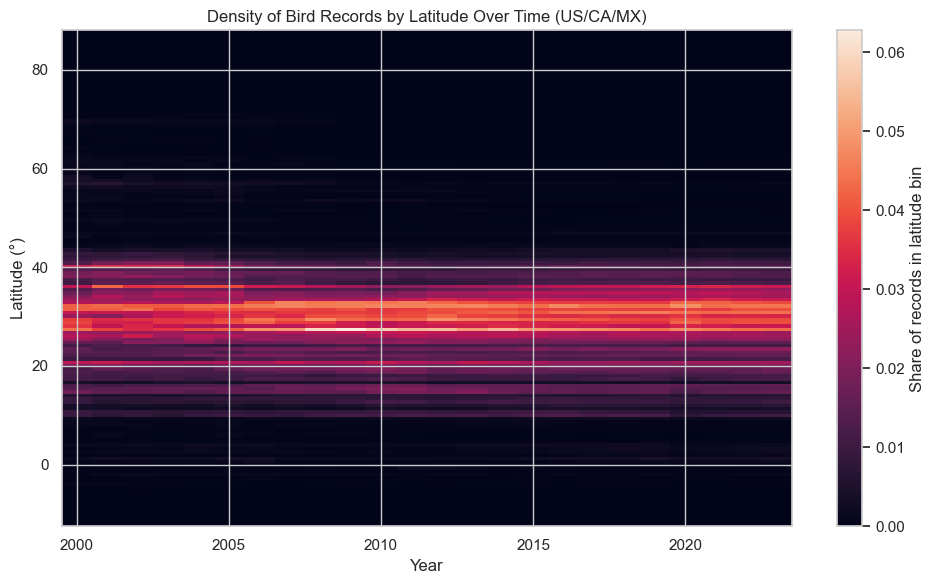

Meaning: brighter bands mark where observations concentrate each year. Upward drift over time = northward shift.


In [150]:
# ------------------------------------------------------
# Plot: Latitude vs Year heatmap (density of records)
# ------------------------------------------------------
# 1) Coerce query outputs to numeric
dfh = df_heat.copy()
dfh["Year"]   = pd.to_numeric(dfh["Year"], errors="coerce")
dfh["LatBin"] = pd.to_numeric(dfh["LatBin"], errors="coerce")
dfh["N"]      = pd.to_numeric(dfh["N"], errors="coerce")
dfh = dfh.dropna(subset=["Year","LatBin","N"])

# 2) Pivot to 2D matrix: rows=LatBin, cols=Year
mat = (dfh.pivot_table(index="LatBin", columns="Year", values="N", aggfunc="sum")
          .fillna(0)
          .sort_index()              # sort latitude ascending
          .sort_index(axis=1))       # sort years ascending

# 3) Normalize column-wise so each year sums to 1 (makes effort comparable)
col_sums = mat.sum(axis=0).replace(0, np.nan)
mat_norm = mat.divide(col_sums, axis=1).fillna(0)

# 4) Plot
fig, ax = plt.subplots(figsize=(10, 6))

im = ax.imshow(
    mat_norm.values.astype(float),     # ensure float
    origin="lower",
    aspect="auto",
    extent=[mat.columns.min()-0.5, mat.columns.max()+0.5,
            mat.index.min(), mat.index.max()]
)

ax.set_title("Density of Bird Records by Latitude Over Time (US/CA/MX)")
ax.set_xlabel("Year")
ax.set_ylabel("Latitude (°)")
cbar = plt.colorbar(im, ax=ax, label="Share of records in latitude bin")
plt.tight_layout()
plt.savefig("figures/rq1_latitude_year_heatmap.png", dpi=200)
plt.show()

print("Meaning: brighter bands mark where observations concentrate each year. Upward drift over time = northward shift.")

In [151]:
# ------------------------------------------------------
# RQ2: Which regions (states/provinces) show the most biodiversity,
#      and how has this changed?  (US, CA, MX; 2000–2023)
#
# In this Section, we compute:
#   - distinct species (species richness) per state/province
#   - total records (for effort context) per state/province
#   - across 3 periods: 2000–2009, 2010–2019, 2020–2023
#
# Notes:
#   * We use stateProvince as provided by GBIF; it's fairly complete for NA.
#   * We filter Aves (birds).
# ------------------------------------------------------

YEAR_MIN, YEAR_MAX = 2000, 2023
COUNTRIES = ("US", "CA", "MX")

sql_rq2 = f"""
WITH base AS (
  SELECT
    year AS Year,
    countryCode AS Country,
    stateProvince AS Region,            -- state/province name (string)
    speciesKey                           -- numeric species ID
  FROM `bigquery-public-data.gbif.occurrences`
  WHERE class = 'Aves'
    AND countryCode IN {COUNTRIES}
    AND year BETWEEN {YEAR_MIN} AND {YEAR_MAX}
    AND speciesKey IS NOT NULL
    AND stateProvince IS NOT NULL
    AND decimalLatitude  IS NOT NULL AND decimalLatitude  != 0
    AND decimalLongitude IS NOT NULL AND decimalLongitude != 0
),
with_period AS (
  SELECT
    CASE
      WHEN Year BETWEEN 2000 AND 2009 THEN '2000-2009'
      WHEN Year BETWEEN 2010 AND 2019 THEN '2010-2019'
      WHEN Year BETWEEN 2020 AND 2023 THEN '2020-2023'
    END AS Period,
    Country,
    Region,
    speciesKey
  FROM base
)
,
richness AS (
  SELECT
    Period, Country, Region,
    COUNT(DISTINCT speciesKey) AS Richness
  FROM with_period
  GROUP BY Period, Country, Region
),
effort AS (
  SELECT
    Period, Country, Region,
    COUNT(*) AS TotalRecords
  FROM with_period
  GROUP BY Period, Country, Region
)
SELECT
  r.Period, r.Country, r.Region,
  r.Richness,
  e.TotalRecords
FROM richness r
JOIN effort   e USING (Period, Country, Region)
ORDER BY Country, Period, Richness DESC
"""

df_rq2 = run_query(sql_rq2, "rq2_richness_us_ca_mx")
df_rq2.head()


,Period,Country,Region,Richness,TotalRecords
0,2000-2009,CA,British Columbia,476,1747841
1,2000-2009,CA,Ontario,465,2437817
2,2000-2009,CA,Quebec,443,4104010
3,2000-2009,CA,Alberta,386,382642
4,2000-2009,CA,Nova Scotia,374,176937


In [152]:
# ------------------------------------------------------
# Light name cleaning so labels are consistent and readable
# ------------------------------------------------------

import re

df2 = df_rq2.copy()

def clean_region(s: str) -> str:
    if not isinstance(s, str):
        return s
    t = s.strip()
    # Common harmonizations:
    t = re.sub(r"\s+", " ", t)
    # Mexico: "Distrito Federal" -> "Ciudad de México" (modern name)
    if t.lower() in {"distrito federal", "cdmx", "ciudad de mexico"}:
        t = "Ciudad de México"
    # English accents normalization (optional; keep accents if you prefer)
    return t

df2["Region"] = df2["Region"].apply(clean_region)

# Keep only rows with non-missing richness
df2 = df2.dropna(subset=["Richness"]).reset_index(drop=True)

# Quick sanity: check coverage by country/period
coverage = (df2.groupby(["Country","Period"])["Region"]
              .nunique()
              .rename("RegionsCount")
              .reset_index())
coverage.head()


,Country,Period,RegionsCount
0,CA,2000-2009,36
1,CA,2010-2019,34
2,CA,2020-2023,22
3,MX,2000-2009,79
4,MX,2010-2019,74


In [153]:
# ------------------------------------------------------
# Focus the charts: pick top N regions per country by latest-period richness.
# ------------------------------------------------------

LATEST = "2020-2023"
TOP_N = 10  # adjust to show more/fewer regions per country

top_by_country = (df2[df2["Period"] == LATEST]
                  .sort_values(["Country","Richness"], ascending=[True, False])
                  .groupby("Country")
                  .head(TOP_N)
                  .loc[:, ["Country","Region"]])

top_regions = set(map(tuple, top_by_country.values))  # {(Country, Region), ...}

df2_top = df2[df2.apply(lambda r: (r["Country"], r["Region"]) in top_regions, axis=1)].copy()
df2_top.head()


,Period,Country,Region,Richness,TotalRecords
0,2000-2009,CA,British Columbia,476,1747841
1,2000-2009,CA,Ontario,465,2437817
2,2000-2009,CA,Quebec,443,4104010
3,2000-2009,CA,Alberta,386,382642
4,2000-2009,CA,Nova Scotia,374,176937


/var/folders/7d/y0dq6pts3c5c4tx5d99hqkch0000gn/T/ipykernel_77469/4119154608.py:27: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = dd.pivot_table(index="Region", columns="Period", values="Richness", aggfunc="sum")[period_order]


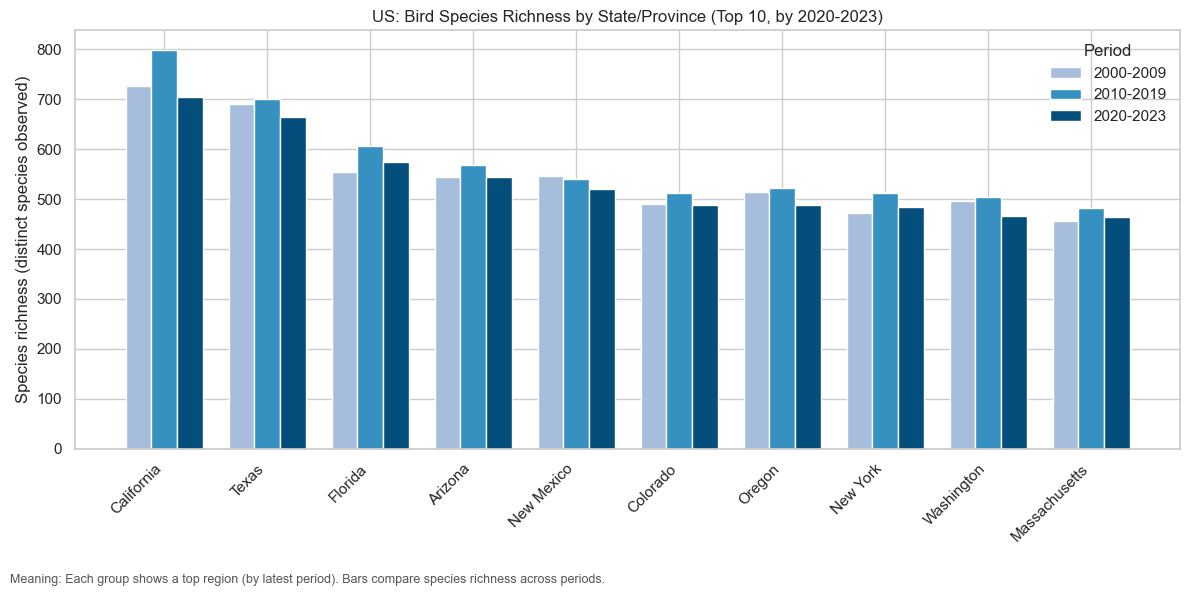

/var/folders/7d/y0dq6pts3c5c4tx5d99hqkch0000gn/T/ipykernel_77469/4119154608.py:27: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = dd.pivot_table(index="Region", columns="Period", values="Richness", aggfunc="sum")[period_order]


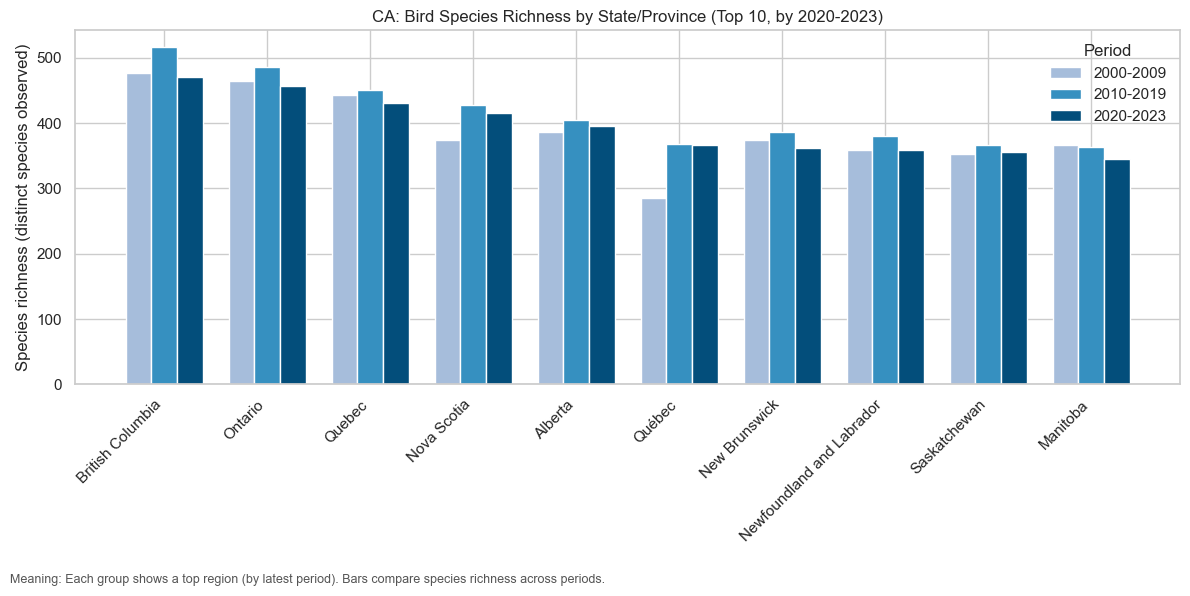

/var/folders/7d/y0dq6pts3c5c4tx5d99hqkch0000gn/T/ipykernel_77469/4119154608.py:27: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = dd.pivot_table(index="Region", columns="Period", values="Richness", aggfunc="sum")[period_order]


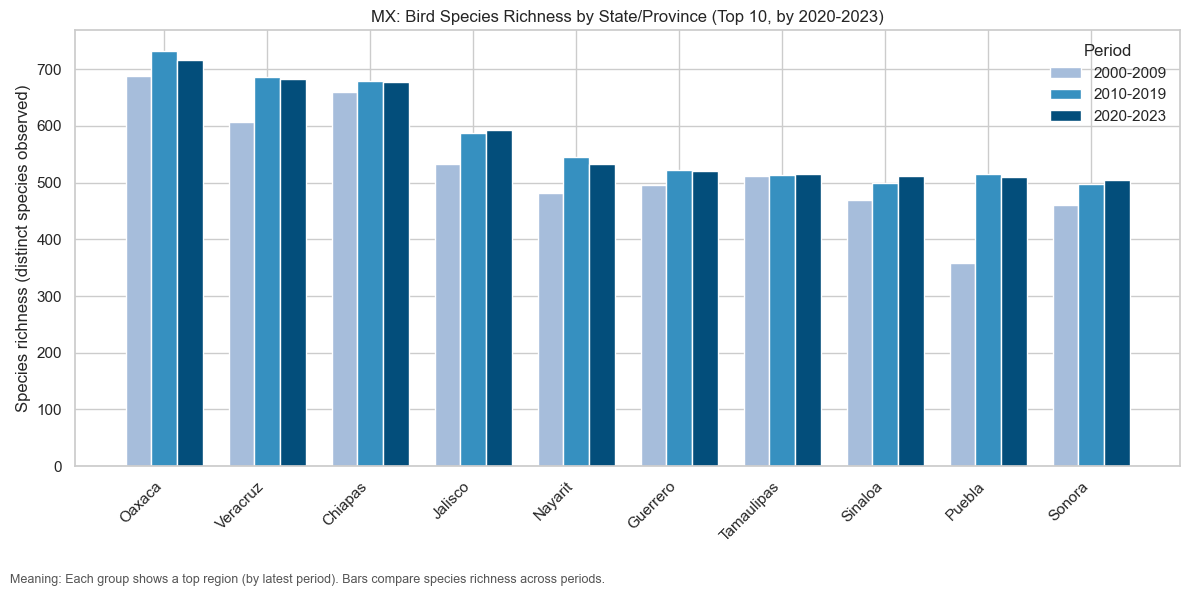

In [154]:
# ------------------------------------------------------
# Viz A: Grouped bars — species richness by region across periods,
#        one figure per country (US, CA, MX).
# Saves: figures/rq2_richness_grouped_<country>.png
# ------------------------------------------------------
import matplotlib.pyplot as plt
import os

os.makedirs("figures", exist_ok=True)

period_order = ["2000-2009", "2010-2019", "2020-2023"]
colors = {"2000-2009":"#a6bddb", "2010-2019":"#3690c0", "2020-2023":"#034e7b"}

for country in ["US","CA","MX"]:
    dd = df2_top[df2_top["Country"]==country].copy()
    if dd.empty:
        continue

    # Order regions by latest-period richness (descending)
    latest_order = (dd[dd["Period"]==LATEST]
                    .sort_values("Richness", ascending=False)["Region"]
                    .tolist())
    dd["Region"] = pd.Categorical(dd["Region"], categories=latest_order, ordered=True)
    dd = dd.sort_values(["Region","Period"])

    # Pivot to have periods as columns for grouped bars
    pivot = dd.pivot_table(index="Region", columns="Period", values="Richness", aggfunc="sum")[period_order]

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    idx = np.arange(len(pivot.index))
    width = 0.25

    for i, p in enumerate(period_order):
        vals = pivot[p].values
        ax.bar(idx + i*width - width, vals, width=width, label=p, color=colors[p])

    ax.set_title(f"{country}: Bird Species Richness by State/Province (Top {TOP_N}, by {LATEST})")
    ax.set_ylabel("Species richness (distinct species observed)")
    ax.set_xticks(idx)
    ax.set_xticklabels(pivot.index, rotation=45, ha="right")
    ax.legend(title="Period", frameon=False)

    # Caption
    plt.gcf().text(0.01, 0.01,
        "Meaning: Each group shows a top region (by latest period). Bars compare species richness across periods.",
        fontsize=9, color="#555", va="bottom")

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    out = f"figures/rq2_richness_grouped_{country}.png"
    plt.savefig(out, dpi=200)
    plt.show()


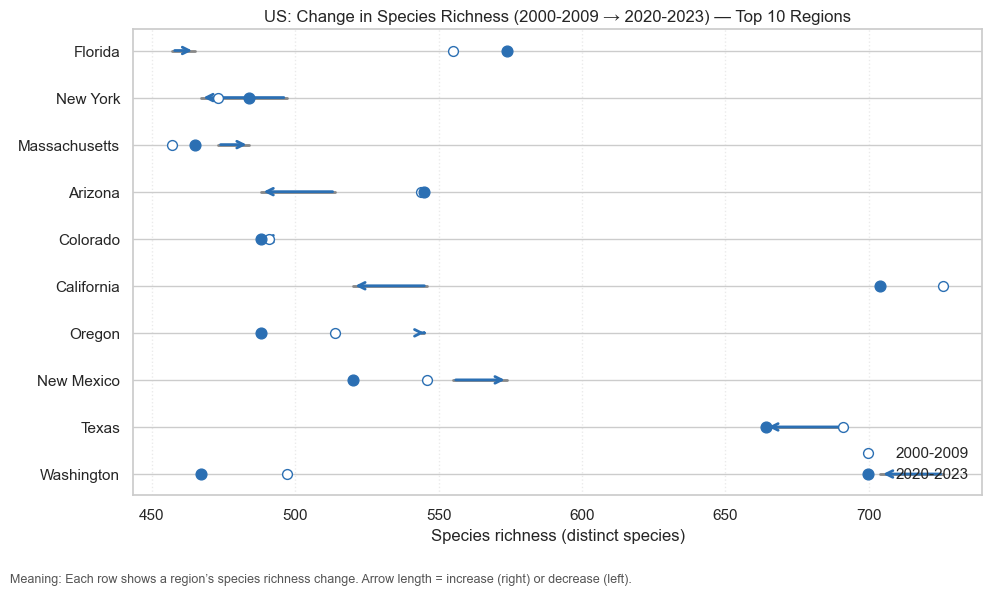

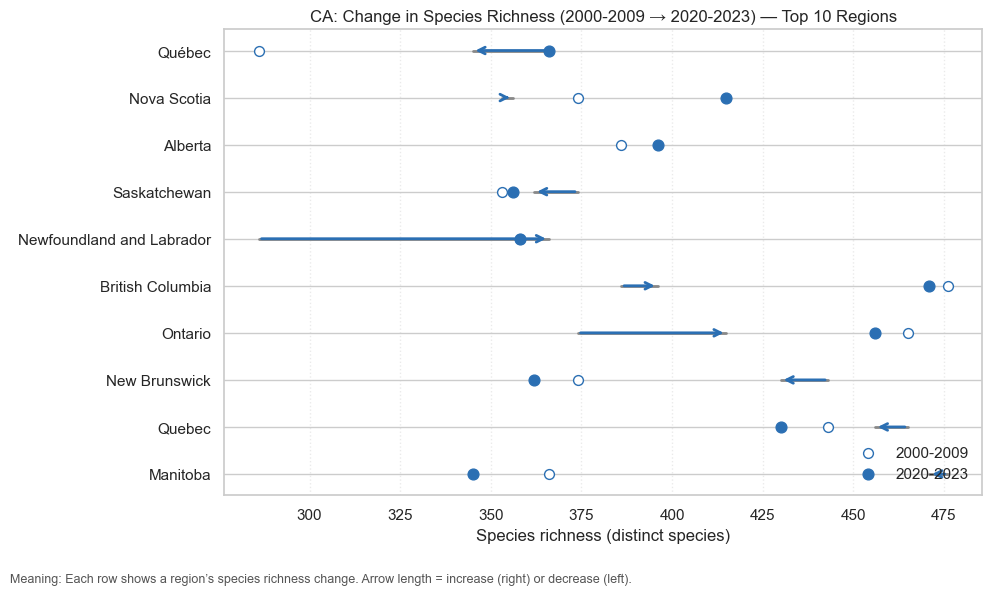

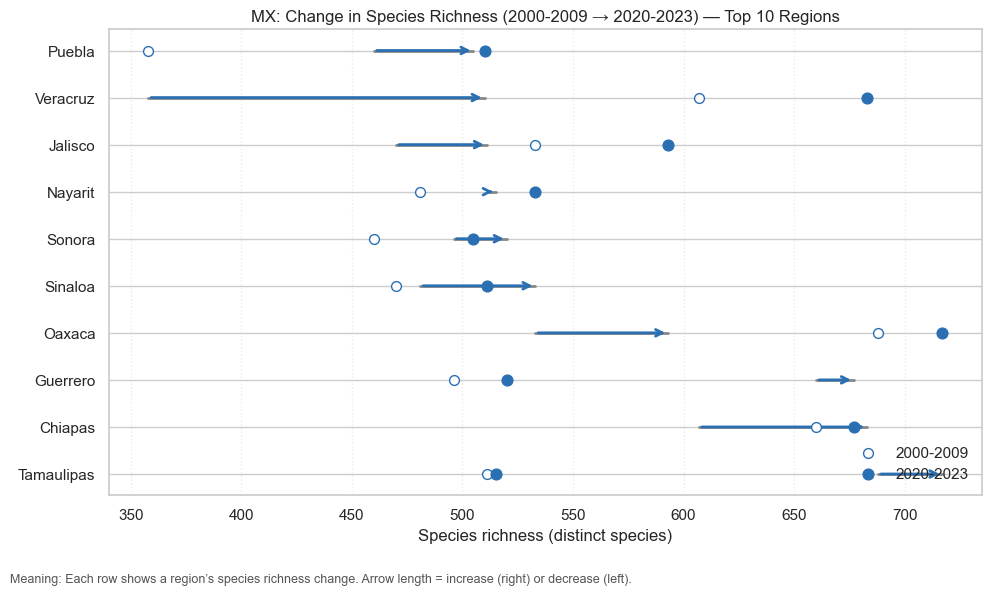

In [155]:
# ------------------------------------------------------
# Viz B: Change arrows — highlight how richness changed
#        from 2000–2009 to 2020–2023, per region (top N per country).
# Saves: figures/rq2_richness_change_<country>.png
# ------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

EARLY, LATE = "2000-2009", "2020-2023"

for country in ["US","CA","MX"]:
    dd = df2_top[df2_top["Country"]==country].copy()
    if dd.empty:
        continue

    early = (dd[dd["Period"]==EARLY][["Region","Richness"]]
             .rename(columns={"Richness":"Richness_Early"}))
    late  = (dd[dd["Period"]==LATE ][["Region","Richness"]]
             .rename(columns={"Richness":"Richness_Late"}))
    cmp = (late.merge(early, on="Region", how="left")
                .fillna({"Richness_Early":0}))
    cmp["Delta"] = cmp["Richness_Late"] - cmp["Richness_Early"]
    cmp = cmp.sort_values("Delta", ascending=True)  # smallest → largest change

    y = np.arange(len(cmp))
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(axis="x", linestyle=":", alpha=0.4)

    # Arrows from early → late
    for i, row in cmp.iterrows():
        ax.plot([row["Richness_Early"], row["Richness_Late"]], [y[i], y[i]], "-", color="#888", lw=2)
        ax.annotate("", xy=(row["Richness_Late"], y[i]), xytext=(row["Richness_Early"], y[i]),
                    arrowprops=dict(arrowstyle="->", color="#2b6fb3", lw=2))

    ax.scatter(cmp["Richness_Early"], y, s=50, facecolors="white", edgecolors="#2b6fb3", label=EARLY, zorder=3)
    ax.scatter(cmp["Richness_Late"],  y, s=60, color="#2b6fb3", label=LATE, zorder=3)

    ax.set_yticks(y)
    ax.set_yticklabels(cmp["Region"])
    ax.set_xlabel("Species richness (distinct species)")
    ax.set_title(f"{country}: Change in Species Richness ({EARLY} → {LATE}) — Top {TOP_N} Regions")

    ax.legend(frameon=False, loc="lower right")
    plt.gcf().text(0.01, 0.01,
        "Meaning: Each row shows a region’s species richness change. Arrow length = increase (right) or decrease (left).",
        fontsize=9, color="#555", va="bottom")

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    out = f"figures/rq2_richness_change_{country}.png"
    plt.savefig(out, dpi=200)
    plt.show()


In [156]:
# Friendly display names for GBIF record types
BOR_LABELS = {
    "HUMAN_OBSERVATION": "Citizen observations (eBird/iNat)",
    "PRESERVED_SPECIMEN": "Institutional specimens",
    "MACHINE_OBSERVATION": "Machine observations",
    "FOSSIL_SPECIMEN": "Fossil specimen",
    "LIVING_SPECIMEN": "Living specimen",
    "MATERIAL_CITATION": "Material citation",
    "MATERIAL_SAMPLE": "Material sample",
    "OBSERVATION": "Observation (legacy/other)",
    "OCCURRENCE": "Occurrence (legacy/other)",
}

def add_caption(text: str, y_pad=0.02):
    """Tiny caption under the plot in plain English."""
    plt.gcf().text(0.01, y_pad, text, fontsize=9, color="#555", va="bottom")

def annotate_last_points(ax, df, xcol, ycol, labelcol):
    """Label the last point of each series with its name + value."""
    for label, g in df.groupby(labelcol):
        g = g.sort_values(xcol)
        x, y = g[xcol].iloc[-1], g[ycol].iloc[-1]
        ax.annotate(f"{BOR_LABELS.get(label,label)}\n{int(y):,}",
                    xy=(x, y), xytext=(6, 0),
                    textcoords="offset points", fontsize=9, va="center")



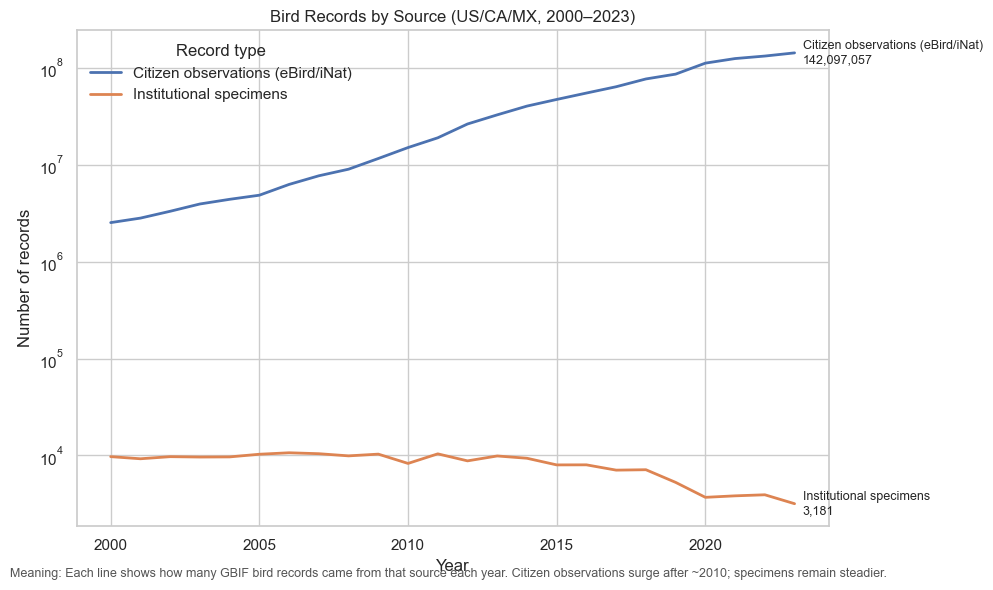

In [157]:
# Keep only the two most informative sources
mask = df_rq3["RecordType"].isin(["HUMAN_OBSERVATION", "PRESERVED_SPECIMEN"])
df_focus = df_rq3[mask].copy().sort_values("Year")

fig, ax = plt.subplots(figsize=(10, 6))

for rt, g in df_focus.groupby("RecordType"):
    ax.plot(g["Year"], g["RecordCount"], linewidth=2, label=BOR_LABELS.get(rt, rt))

ax.set_title(f"Bird Records by Source (US/CA/MX, {df_focus['Year'].min()}–{df_focus['Year'].max()})")
ax.set_xlabel("Year")
ax.set_ylabel("Number of records")

# Log scale makes both series readable despite different magnitudes
ax.set_yscale("log")
ax.legend(title="Record type", frameon=False, loc="upper left")

annotate_last_points(ax, df_focus, xcol="Year", ycol="RecordCount", labelcol="RecordType")
add_caption("Meaning: Each line shows how many GBIF bird records came from that source each year. "
            "Citizen observations surge after ~2010; specimens remain steadier.")

plt.tight_layout()
plt.savefig("figures/rq3_records_citizen_vs_specimens.png", dpi=200)
plt.show()


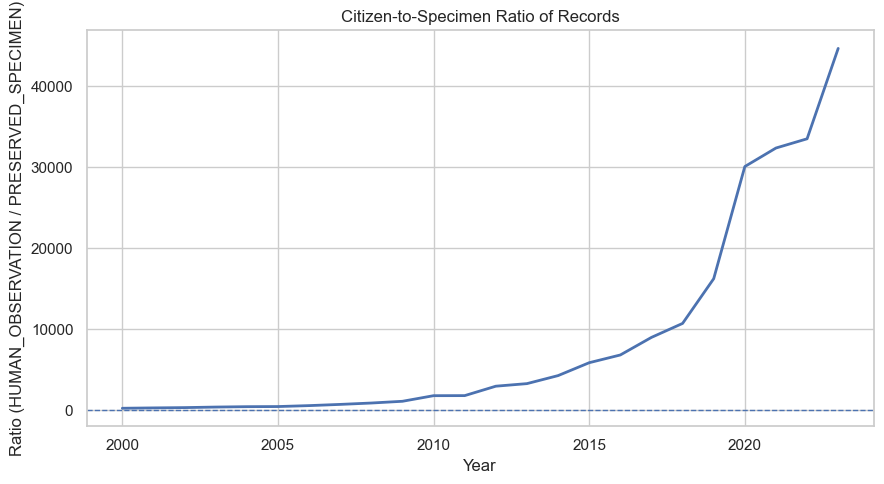

In [158]:
# Compute ratio (citizen vs preserved specimens) per year
p = piv  # from Option A (year × type)
cit = p.get("HUMAN_OBSERVATION", pd.Series(index=p.index, dtype=float))
spec = p.get("PRESERVED_SPECIMEN", pd.Series(index=p.index, dtype=float))
ratio = (cit / spec).replace([np.inf, -np.inf], np.nan)

fig, ax = plt.subplots(figsize=(9,5))
ax.plot(ratio.index, ratio.values, linewidth=2)
ax.axhline(1, linestyle="--", linewidth=1)  # 1 = equal contributions
ax.set_title("Citizen-to-Specimen Ratio of Records")
ax.set_xlabel("Year"); ax.set_ylabel("Ratio (HUMAN_OBSERVATION / PRESERVED_SPECIMEN)")
plt.tight_layout(); plt.savefig("figures/rq3_citizen_specimen_ratio.png", dpi=200); plt.show()


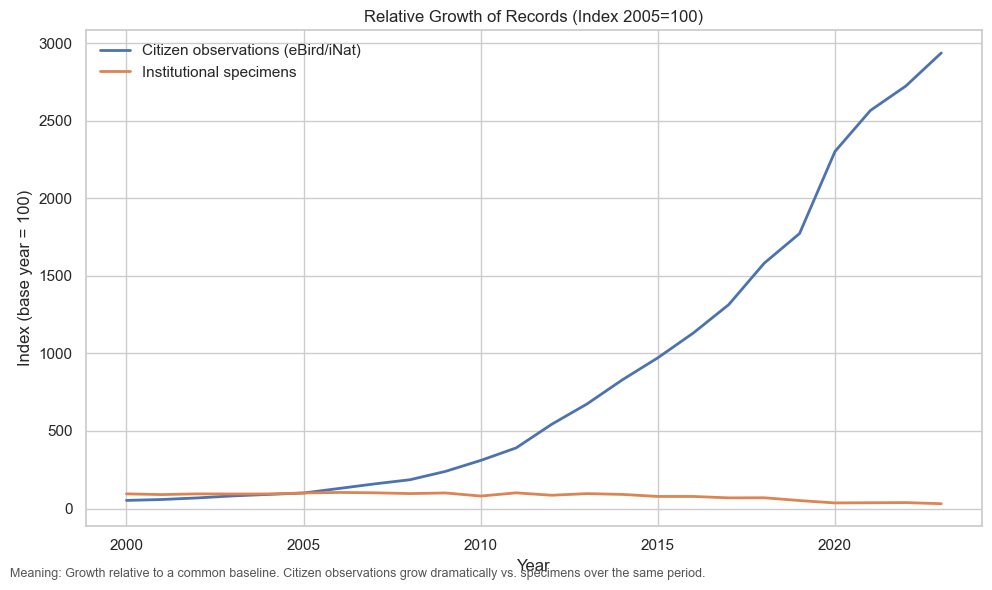

In [159]:
base_year = 2005  # choose a pre-surge baseline

# Prepare a two-series table again
df_idx = df_rq3[df_rq3["RecordType"].isin(["HUMAN_OBSERVATION","PRESERVED_SPECIMEN"])].copy()
df_idx = df_idx.sort_values(["RecordType","Year"])

# Compute index = 100 at base_year for each series
base_vals = (df_idx[df_idx["Year"]==base_year]
             .set_index("RecordType")["RecordCount"].to_dict())

def to_index(row):
    base = base_vals.get(row["RecordType"], np.nan)
    return (row["RecordCount"]/base*100) if (pd.notna(base) and base>0) else np.nan

df_idx["Index"] = df_idx.apply(to_index, axis=1)

fig, ax = plt.subplots(figsize=(10, 6))
for rt, g in df_idx.groupby("RecordType"):
    ax.plot(g["Year"], g["Index"], linewidth=2, label=BOR_LABELS.get(rt, rt))

ax.set_title(f"Relative Growth of Records (Index {base_year}=100)")
ax.set_xlabel("Year")
ax.set_ylabel("Index (base year = 100)")
ax.legend(frameon=False, loc="upper left")

add_caption("Meaning: Growth relative to a common baseline. "
            "Citizen observations grow dramatically vs. specimens over the same period.")

plt.tight_layout()
plt.savefig("figures/rq3_growth_index.png", dpi=200)
plt.show()


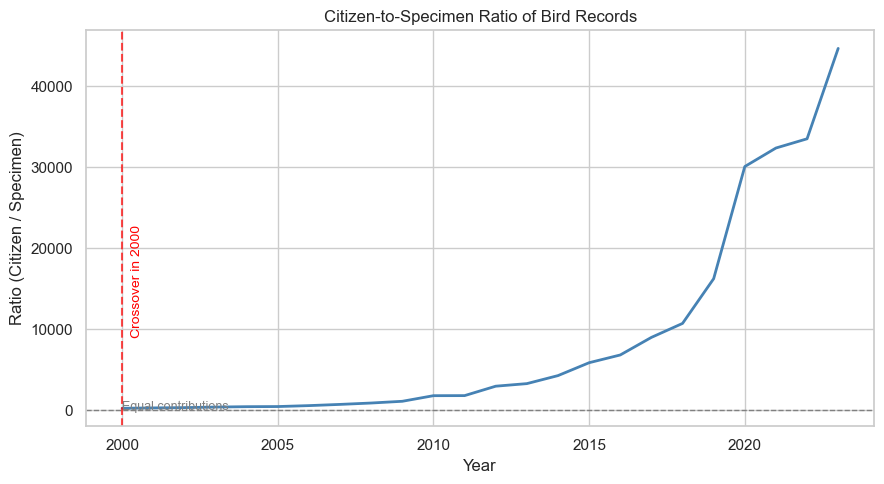

Citizen science first surpassed specimens in 2000.


In [160]:
# ------------------------------------------------------
# Annotated Citizen-to-Specimen Ratio
# ------------------------------------------------------

# Find first year citizen science > specimens
crossover_year = ratio[ratio > 1].index.min()

fig, ax = plt.subplots(figsize=(9,5))
ax.plot(ratio.index, ratio.values, linewidth=2, color="steelblue")

# Horizontal reference at 1.0 (equal contributions)
ax.axhline(1, linestyle="--", linewidth=1, color="gray")
ax.text(ratio.index.min(), 1.05, "Equal contributions", color="gray", fontsize=9)

# Vertical line for crossover year
if pd.notna(crossover_year):
    ax.axvline(crossover_year, linestyle="--", color="red", alpha=0.7)
    ax.text(crossover_year+0.3, ratio.max()*0.2, 
            f"Crossover in {crossover_year}", 
            color="red", fontsize=10, rotation=90, va="bottom")

ax.set_title("Citizen-to-Specimen Ratio of Bird Records")
ax.set_xlabel("Year")
ax.set_ylabel("Ratio (Citizen / Specimen)")

plt.tight_layout()
plt.savefig("figures/rq3_citizen_specimen_ratio_annotated.png", dpi=200)
plt.show()

print(f"Citizen science first surpassed specimens in {crossover_year}.")


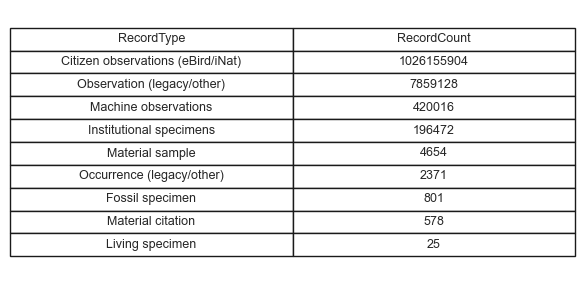

,RecordType,RecordCount
0,Citizen observations (eBird/iNat),1026155904
1,Observation (legacy/other),7859128
2,Machine observations,420016
3,Institutional specimens,196472
4,Material sample,4654
5,Occurrence (legacy/other),2371
6,Fossil specimen,801
7,Material citation,578
8,Living specimen,25


In [161]:
# ------------------------------------------------------
# Totals by record type (2000–2023)
# ------------------------------------------------------

summary = (df_rq3
           .groupby("RecordType")["RecordCount"]
           .sum()
           .sort_values(ascending=False)
           .reset_index())

summary["RecordType"] = summary["RecordType"].map(BOR_LABELS).fillna(summary["RecordType"])

# Display as a table
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,3))
ax.axis("off")
table = ax.table(cellText=summary.values,
                 colLabels=summary.columns,
                 cellLoc="center",
                 loc="center")
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2)

plt.tight_layout()
plt.savefig("figures/rq3_summary_table.png", dpi=200)
plt.show()

summary
